# Denoising Diffusion Probabilistic Models

In [1]:
from typing import NamedTuple

import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from sklearn import metrics

In [2]:
def q(x0, at, rng):
    return jnp.sqrt(at) * x0 + jnp.sqrt(1 - at) * jax.random.normal(rng, x0.shape)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = jnp.array(X_train / 127.5 - 1)
X_test = jnp.array(X_test / 127.5 - 1)

In [4]:
rng = jax.random.PRNGKey(0)

Below, we can see the forward diffusion process.

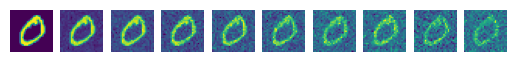

In [5]:
bt = jnp.linspace(0, 1, num=100)
at = jnp.cumprod(1 - bt)
r = rng

T = 10
_, arr = plt.subplots(1, T)
for i in range(T):
    r, _ = jax.random.split(r)
    arr[i].imshow(
        q(X_train[1], at[i], r)
    )
    arr[i].axis("off")

In [33]:
def mlp(p, X):
    S0 = jnp.zeros_like(X)
    S1 = jnp.zeros_like(X)
    for l, (W, b) in enumerate(p):
        if l == (len(p) - 1):
            X = X + S0
        if l == (len(p) - 2):
            X = X + S1
        X = X @ W + b
        if (l + 1) < len(p):
            X = nn.relu(X)
        if l == 0:
            S0 = X
        if l == 1:
            S1 = X
    return X


class AdamParam(NamedTuple):
    m: tuple
    v: tuple
    eta: float = 2e-3
    betas: tuple = (0.9, 0.999)
    t: int = 0

    @classmethod
    def init(cls, p, eta):
        m = jax.tree_map(jnp.zeros_like, p)
        v = jax.tree_map(jnp.zeros_like, p)
        return cls(m, v, eta)
    
    def update(self, G):
        t = self.t + 1
        b1, b2 = self.betas
        
        mt = jax.tree_map(
            lambda m, g: b1 * m + (1 - b1) * g, self.m, G
        )
        vt = jax.tree_map(
            lambda v, g: b2 * v + (1 - b2) * g ** 2, self.v, G
        )
        return AdamParam(mt, vt, self.eta, self.betas, t)


@jax.jit
def train_step(p, X, eps, lambda_, adam_params):
    def loss(p):
        eps_hat = mlp(p, X)
        return (
            jnp.mean(jnp.linalg.norm(eps - eps_hat, axis=1) ** 2)
            + lambda_ * jax.tree_util.tree_reduce(
                lambda i, w: jnp.linalg.norm(w) ** 2, p, jnp.zeros(())
            )
        )

    l, G = jax.value_and_grad(loss)(p)
    adam_params = adam_params.update(G)
    return update_params(p, G, adam_params), l, adam_params


def update_params(p, G, adam_params):
    t = adam_params.t
    b1, b2 = adam_params.betas
    mt = adam_params.m
    vt = adam_params.v

    eps = jnp.finfo(jnp.float32).eps
    eta = adam_params.eta
    return jax.tree_map(lambda w, m_, v_: w - eta * m_ / (1 - b1 ** t) / (jnp.sqrt(v_ / (1 - b2 ** t)) + eps), p, mt, vt)

In [7]:
def get_batch_indices(rng, dataset_size, batch_size):
    steps_per_epoch = dataset_size // batch_size

    perms = jax.random.permutation(rng, dataset_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    return perms

In [8]:
def kaiming(n):
    return jnp.sqrt(2 / n)

def init_layer(shape, rng):
    kW, kb = jax.random.split(rng)
    s = kaiming(shape[-1])
    W = jax.random.normal(kW, shape) * s
    b = jax.random.normal(kb, shape[-1:]) * s
    return W, b


In [9]:
def pos_enc(t, d):
    k = jnp.arange(0, d, 2, dtype=jnp.float32) / d
    z = t.reshape(-1, 1) / (10_000 ** k)

    s = jnp.sin(z)
    c = jnp.cos(z)
    return jnp.zeros((len(t), d), dtype=jnp.float32).at[:, 0::2].set(s).at[:, 1::2].set(c)


In [34]:
r = rng
pM0 = ()
for shape in [
    (28 ** 2 + 4, 2048),
    (2048, 1024),
    (1024, 512),
    (512, 1024),
    (1024, 2048),
    (2048, 28 ** 2),
]:
    _, _, r = jax.random.split(r, 3)
    pM0 = pM0 + (init_layer(shape, r),)


In [35]:
T = 1000
min_b = 1e-4
max_b = 0.02
v = jnp.linspace(min_b, max_b, num=T)

# bt = (v / max_b) ** 0.5 * v
bt = v
at = jnp.cumprod(1 - bt).reshape(-1, 1)
r = rng
p = pM0

E = 41
B = 128
X = X_train.reshape(len(X_train), -1)

P = jnp.zeros(T) - jnp.log(T)
sqat = jnp.sqrt(at)
sqmat = jnp.sqrt(1 - at)

Tenc = pos_enc(jnp.arange(0, T), 4)
adam_params = AdamParam.init(p, eta=5e-4)
for e in range(E):
    r, r0 = jax.random.split(r)
    ix = get_batch_indices(r0, len(X_train), B)

    L = jnp.array(0)
    for i in tqdm.tqdm(ix, desc=f"Epoch {e}"):
        r, r0, r1, r2 = jax.random.split(r, 4)

        t = jax.random.categorical(r0, P, shape=i.shape)
        X_ = X[i]
        eps = jax.random.normal(r2, X_.shape)
        X_t = sqat[t] * X_ + sqmat[t] * eps

        p, l, adam_params = train_step(
            p,
            jnp.hstack((X_t, Tenc[t])),
            eps,
            lambda_=1e-5,
            adam_params=adam_params
        )
        L += l
    print(f"Mean error of epoch {e}: {(L / len(ix)).item():.3f}")


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.28it/s]


Mean error of epoch 0: 816.484


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.94it/s]


Mean error of epoch 1: 267.339


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.14it/s]


Mean error of epoch 2: 189.140


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.25it/s]


Mean error of epoch 3: 166.291


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.46it/s]


Mean error of epoch 4: 152.428


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.75it/s]


Mean error of epoch 5: 142.960


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.65it/s]


Mean error of epoch 6: 138.252


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.76it/s]


Mean error of epoch 7: 131.722


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.59it/s]


Mean error of epoch 8: 128.927


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.66it/s]


Mean error of epoch 9: 126.636


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.87it/s]


Mean error of epoch 10: 123.163


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.78it/s]


Mean error of epoch 11: 123.642


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.55it/s]


Mean error of epoch 12: 121.119


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.54it/s]


Mean error of epoch 13: 120.437


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.79it/s]


Mean error of epoch 14: 120.195


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.75it/s]


Mean error of epoch 15: 118.995


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.71it/s]


Mean error of epoch 16: 118.086


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.80it/s]


Mean error of epoch 17: 118.612


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.80it/s]


Mean error of epoch 18: 117.648


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.79it/s]


Mean error of epoch 19: 118.125


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.82it/s]


Mean error of epoch 20: 118.131


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.74it/s]


Mean error of epoch 21: 116.656


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.68it/s]


Mean error of epoch 22: 117.028


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.76it/s]


Mean error of epoch 23: 116.584


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.97it/s]


Mean error of epoch 24: 114.663


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.40it/s]


Mean error of epoch 25: 115.670


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.50it/s]


Mean error of epoch 26: 115.953


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.27it/s]


Mean error of epoch 27: 115.929


Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.48it/s]


Mean error of epoch 28: 114.422


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.30it/s]


Mean error of epoch 29: 116.172


Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.34it/s]


Mean error of epoch 30: 116.346


Epoch 31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.37it/s]


Mean error of epoch 31: 115.665


Epoch 32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.37it/s]


Mean error of epoch 32: 115.118


Epoch 33: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.25it/s]


Mean error of epoch 33: 114.987


Epoch 34: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.01it/s]


Mean error of epoch 34: 113.995


Epoch 35: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.20it/s]


Mean error of epoch 35: 114.330


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.25it/s]


Mean error of epoch 36: 113.365


Epoch 37: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.63it/s]


Mean error of epoch 37: 113.578


Epoch 38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.77it/s]


Mean error of epoch 38: 113.280


Epoch 39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.70it/s]


Mean error of epoch 39: 113.750


Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.69it/s]

Mean error of epoch 40: 113.720


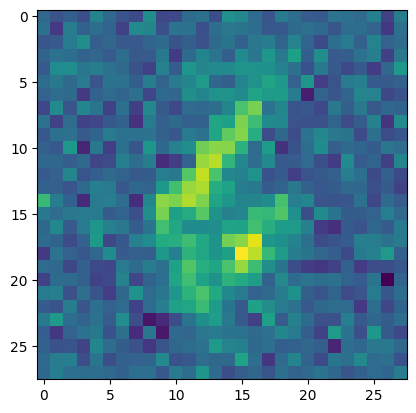

In [36]:
r = rng

I = jax.random.normal(r, (1, 28 ** 2))
for t_ in [*range(T)][::-1]:
    r, r0 = jax.random.split(r)
    z = jax.random.normal(r0, I.shape)
    I = (
        1 / jnp.sqrt(1 - bt[t_])
        * (I - bt[t_] / jnp.sqrt(1 - at[t_][0]) * mlp(p, jnp.hstack((I, pos_enc(jnp.array([[t_]]), 4)))))
        + jnp.sqrt(bt[t_]) * z * (t_ > 0)
    )
    if jnp.any(jnp.isnan(I) | ~jnp.isfinite(I)):
        break

plt.imshow(I.reshape(28, 28))

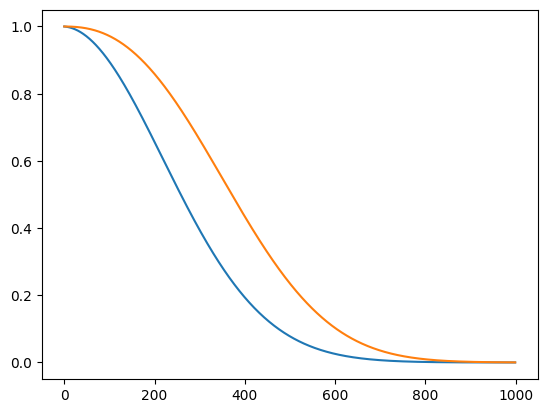

In [402]:
min_b = 1e-4
max_b = 0.02
v = jnp.linspace(min_b, max_b, num=T)

bt0 = v
bt1 = (v / max_b) ** 0.5 * v
at0 = jnp.cumprod(1 - bt0).reshape(-1, 1)
at1 = jnp.cumprod(1 - bt1).reshape(-1, 1)
plt.plot(at0.ravel())
plt.plot(at1.ravel())

## Appendix

Some additional derivations (for my own benefit)

### Variational lower bound

_a.k.a Evidence Lower Bound (ELBO)_

Suppose we want to know the marginal log probability $\log p(x)$ of random variable $x$, which is jointly distributed with latent variable $z$, such that:

$$
\log p(x) = \log \int p(x, z) \, dz
$$

Then, we have

$$\begin{align}
\log p(x) &= \log \int p(x, z) \, dz \\
&= \log \int p(x, z) \frac{p(z|x)}{p(z|x)} \, dz \\
&= \log \mathbb{E}_{p(z|x)}\left[\frac{p(x, z)}{p(z|x)}\right]
\end{align}$$

We then swap out the true posterior $p(z|x)$ with its variational approximation $q(z)$ and apply Jensen's inequality:

$$\begin{align}
\log \mathbb{E}_q\left[\frac{p(x, z)}{q(z)}\right] &\geq \mathbb{E}_q\left[\log \frac{p(x, z)}{q(z)}\right] \\
&= \mathbb{E}_q\left[\log p(x, z)\right] - \mathbb{E}_q[\log q(z)] \\
&= \mathbb{E}_q\left[\log p(x, z)\right] + \mathbb{H}_q[z]
\end{align}$$

where $\mathbb{H}_q[z]$ is the Shannon entropy of $z$.

In the case of DDPM, we have the the marginal $p(x_0) = \int p(x_{0:T}) \, dx_{1:T}$ (marginalising out the latents $x_{1:T}$). Applying the above, we get:

$$\begin{align}
\log p(x_0) &= \log \int p(x_{0:T}) \, dz \\
&= \log \int p(x_{0:T}) \frac{p(x_{1:T}|x_0)}{p(x_{1:T}|x_0)} \, dz \\
&= \log \mathbb{E}_{p(x_{1:T}|x_0)}\left[\frac{p(x_{0:T})}{p(x_{1:T}|x_0)}\right] \\
&\geq \mathbb{E}_{p(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{p(x_{1:T}|x_0)}\right]
\end{align}$$

Again, we replace the the true posterior $p$ with the variational form $q$ (which in this case is the forward diffusion process):

$$
\mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\right]
$$

Now, defining the reverse process $p$:

$$\begin{align}
p(x_{0:T}) &= p(x_T) \prod_{t = 1}^T p(x_{t - 1} | x_t) \\
% p(x_T) &= \mathcal{N}(x_T; 0, I) \\
% p(x_{t - 1} | x_t) &= \mathcal{N}(x_{t - 1}; \mu(x_t, t), \Sigma(x_t, t))
\end{align}$$

and the forward process $q$:

$$\begin{align}
q(x_{1:T} | x_0) &= \prod_{t = 1}^T q(x_t | x_{t - 1}) \\
% q(x_t | x_{t - 1}) &= \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t - 1}, \beta_t I)
\end{align}$$

Placing these into the ELBO:

$$\begin{align}
\mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\right] &= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_T) \prod_{t = 1}^T p(x_{t - 1} | x_t)}{\prod_{t = 1}^T q(x_t | x_{t - 1})}\right] \\
&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log p(x_T) + \log \frac{\prod_{t = 1}^T p(x_{t - 1} | x_t)}{\prod_{t = 1}^T q(x_t | x_{t - 1})}\right] \\
&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log p(x_T) + \sum_{t = 1}^T \log \frac{p(x_{t - 1} | x_t)}{q(x_t | x_{t - 1})}\right]
\end{align}$$

Since we are in the deep learning space, we will want to minimize a loss $L$ instead of maximising the log-likelihood. Hence, we multiply by $-1$:

$$
L := \mathbb{E}_{q(x_{1:T}|x_0)}\left[- \log p(x_T) - \sum_{t = 1}^T \log \frac{p(x_{t - 1} | x_t)}{q(x_t | x_{t - 1})}\right]
$$

et viola, we have Equation 3 from the paper.

### Closed Form $p(x_t)$

Next, we will try to recover Equation 4 from the paper. We start by defining the forward process $q$:

$$\begin{align}
q(x_{1:T} | x_0) &= \prod_{t = 1}^T q(x_t | x_{t - 1}) \\
q(x_t | x_{t - 1}) &= \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t - 1}, \beta_t I)
\end{align}$$

via reparameterisation:

$$
x_t = \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{\beta_t} \epsilon_t
$$

where

$$
\epsilon_t \sim \mathcal{N}(0, I)
$$

Expanding the recursive reparameterisation out a bit, we will start to see a pattern:

$$\begin{align}
x_{t + 1} &= \sqrt{1 - \beta_{t + 1}} \left( \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{\beta_t} \epsilon_t \right) + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \\ 
&= \sqrt{1 - \beta_{t + 1}} \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{1 - \beta_{t + 1}} \sqrt{\beta_t} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \\
&= \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} + \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1}
\end{align}$$

Let's first consider the mean at timestep $t$. In the above expression we can see that we scale $x_{t - 1}$ (which is $x_0$ if we follow the recursion all the way through) and add some scaled noise (centered around 0). Since $\mathbb{E}[\epsilon_t] = 0$, the location of $x_t$ does not depend on $\epsilon_t$. Instead, it entirely depends on $x_0$ and how that is scaled. Hence, we can express the mean $\mu_t$ of $q(x_t | x_{t - 1})$ as follows:

$$\begin{align}
\mu_t &= \sqrt{\bar{\alpha}_t} x_0 \\
\bar{\alpha}_t &= \prod_{s = 1}^t \alpha_s \\
\alpha_s &= 1 - \beta_s
\end{align}$$

And the variance component:

$$\begin{align}
\mathbb{V}[x_{t + 1}] &= \mathbb{V}\left[ \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} + \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \mathbb{V}\left[ \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} \right] + \mathbb{V} \left[ \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t \right] + \mathbb{V} \left[ \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \mathbb{V} \left[ \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t \right] + \mathbb{V} \left[ \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \beta_t (1 - \beta_{t + 1}) \mathbb{V} \left[ \epsilon_t \right] + \beta_{t + 1} \mathbb{V} \left[ \epsilon_{t + 1} \right] \\
&= \beta_t (1 - \beta_{t + 1}) + \beta_{t + 1} \\
\end{align}$$

Now, first consider the case where $t = 1$, then our variance will be $\beta_t = 1 - \bar{\alpha}_t$. By induction, then, we can show that $V[x_t] = 1 - \bar{\alpha}_t$. Suppose adding another time step $t + 1$, like below:

$$\begin{align}
1 - \hat{\alpha}_t &= 1 - \prod_s^t (1 - \beta_s) \\
&= 1 - (1 - \beta_t)(1 - \beta_{t + 1}) \\
&= 1 - (1 - \beta_t - \beta_{t + 1} + \beta_t\beta_{t + 1}) \\
&= \beta_t + \beta_{t + 1} - \beta_t\beta_{t + 1} \\
&= \beta_t (1 - \beta_{t + 1}) + \beta_{t + 1}
\end{align}$$

(and so on...)

So we recover equation 4:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
$$